# CSE 343 Machine Learning A-1

## Q3 Naive Bayes

### Preprocessing and EDA

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import idx2numpy

## loading the dataset
x_train = idx2numpy.convert_from_file("train-images-idx3-ubyte")
x_test = idx2numpy.convert_from_file("t10k-images-idx3-ubyte")
y_train = idx2numpy.convert_from_file("train-labels-idx1-ubyte")
y_test = idx2numpy.convert_from_file("t10k-labels-idx1-ubyte")


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [13]:
## picking only trouser(1) and pullover(2) datapoints
x_train=x_train[(y_train==1) | (y_train==2)]
y_train=y_train[(y_train==1) | (y_train==2)]

x_test=x_test[(y_test==1) | (y_test==2)]
y_test=y_test[(y_test==1) | (y_test==2)]

xtr=[]
for i in range(x_train.shape[0]):
    
    ## binarizing pixel values to 0,255
    c1=(x_train[i]<=127).sum()
    c2=(x_train[i]>127).sum()
    xtr.append([c1,c2])
    
xte=[]
for i in range(x_test.shape[0]):
    
    c1=(x_test[i]<=127).sum()
    c2=(x_test[i]>127).sum()
    xte.append([c1,c2])
    
x_test = np.array(xte)
x_train = np.array(xtr)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12000, 2), (2000, 2), (12000,), (2000,))

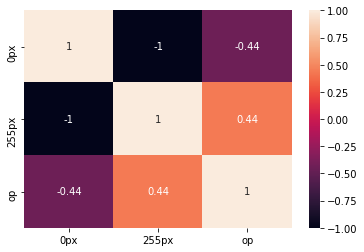

In [14]:
import seaborn as sns

df_train = pd.DataFrame(data=np.c_[x_train,y_train],columns=["0px","255px","op"])
df_test = pd.DataFrame(data=np.c_[x_test,y_test],columns=["0px","255px","op"])

df_train["op"].value_counts(),df_test["op"].value_counts()

## creating correlation matrix for the dataset
ax = sns.heatmap(df_train.corr(), annot=True)

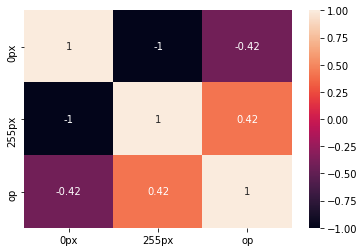

In [8]:
axx = sns.heatmap(df_test.corr(), annot=True)

### 3.1 Coding Naive Bayes Class

In [9]:
class Naive_Bayes:
    
    def __init__(self):
        ## dictionary to store final result
        ## format of dictionary = <label, d2> where d2 is another dictionary
        ## d2 = <feature,frequency of feature>
        
        ## for example - a trouser image with 400 pixels with value 0 and 384 pixels with value 255
        ## will look like this = result[1][0]=400 and result[1][255]=384
        
        ## along with this, the dictionary result also has a key to store total count
        ## result["total_data"] = total number of datapoints
        ## every class also has a count member = result[1]["total_count"] and result[2]["total_count"]
        self.result = {}
    
    ## function to fit the data to model (training)
    def fit(self, x, y):
        
        ## get all unique class values (1 and 2 in this case)
        class_values = set(y)
        
        self.result["total_data"] = len(y)
        
        for current_class in class_values:
            
            self.result[current_class] = {}
                 
            ## get all data points of current class
            x_current = x[y==current_class]
            y_current = y[y==current_class]
            
            num_features = x.shape[1]
            ## total members of current class
            self.result[current_class]["total_count"] = len(y_current)
            
            for j in range(1,num_features+1):
                
                self.result[current_class][j]= {}
                
                ## initialization
                for i in range(784):
                    self.result[current_class][j][i]=0
                    
                ## all possible values of feature at j'th position
                all_possible_values = set(x[:,j-1])
                
                ## storing frequency count of j'th feature
                for current_value in all_possible_values:
                    
                    self.result[current_class][j][current_value] = (x_current[:,j-1]==current_value).sum()
                    
    
    ## calculate probability of data_point belonging to current_class
    def probability(self, data_point, current_class):
        
        ## this is for weighted addition / multiplication of probabilities
        ## we take log probabilities as it might be a small number and 
        ## multiplication of many small numbers will give a very small number
        ## which is difficult to operate upon
        output = np.log(self.result[current_class]["total_count"])-np.log(self.result["total_data"])
        
        num_features = len(self.result[current_class].keys())-1
        
        ## iterate over all features to calculate probability
        for j in range(1, num_features+1):
            
            ## value of feature j for current_class
            xj = data_point[j-1]
            
            ## numerator
            count_current_class_with_value_xj = self.result[current_class][j][xj]+1 ## 1 added for correction
            
            ## denominator
            count_current_class = self.result[current_class]["total_count"] + len(self.result[current_class][j].keys())
            
            current_xj_probability = np.log(count_current_class_with_value_xj) - np.log(count_current_class)
        
            output = output + current_xj_probability
            
        return output
       
    ## makes prediction for a single data point. Finds the probability of the
    ## data point belonging to every class and assigns the class having
    ## maximum probability
    def predict_single_point(self, data_point):
        
        all_classes = self.result.keys()
        
        best_p = -float("inf")
        best_class = -1
        first_run = True
        
        for current_class in all_classes:
            
            if current_class == "total_data":
                continue
                
            p_current_class = self.probability(data_point, current_class)
            
            if first_run or p_current_class > best_p:
                best_p = p_current_class
                best_class = current_class
                
            first_run = False
            
        return best_class
        
    ## to be called on testing data. It will make predictions for each
    ## data point and append it in an array
    def predict(self, x):
        
        y_pred = []
        
        for data_point in x:
            
            data_point_class = self.predict_single_point(data_point)
            y_pred.append(data_point_class)
            
        return y_pred
    
    
    ## returns list of probabilities of all classes
    def get_proba_helper(self,data_point):
        
        proba = []
        
        all_classes = self.result.keys()
        
        for current_class in all_classes:
            
            if current_class == "total_data":
                continue
                
            p_current_class = self.probability(data_point, current_class)
            proba.append(p_current_class)
          
        return np.array(proba)
        
        
        
    ## returns probability of a data point belonging to a specified class
    def get_proba(self,x):
        
        y_proba = []
        
        for i in range(len(x)):
            
            data_point = x[i]
            probs = np.exp(self.get_proba_helper(data_point))
            y_proba.append(probs/probs.sum())
        return np.array(y_proba)
    
    
## function to find mean accuracy. This is written outside the class so that we can use it without 
## creating an object as well, for more efficient useage.

def score(y_pred, y_test):
    count=0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            count+=1
    return count/len(y_pred)

In [10]:
## running model without KFold 
naive_bayes = Naive_Bayes()
naive_bayes.fit(x_train, y_train)
y_pred = naive_bayes.predict(x_test)
print("Train Score:",score(naive_bayes.predict(x_train),y_train))
print("Test Score:",score(naive_bayes.predict(x_test),y_test))

Train Score: 0.8714166666666666
Test Score: 0.8365


### 3.2 K-Fold Cross Validation

In [11]:
def KFold(k,x,y):
    
    scores = []
    
    fold_size = len(x)//k
    
    for i in range(k):
        
        
        x_test = x[i*fold_size:(i+1)*fold_size]
        y_test = y[i*fold_size:(i+1)*fold_size]
        
        if i>0:
            
            if i==k-1:
                x_train=x[:i*fold_size]
                y_train=y[:i*fold_size]
            
            else:
                p = x[(i-1)*fold_size:i*fold_size]
                n = x[(i+1)*fold_size:]
                x_train=np.concatenate((p,n))
                
                p = y[(i-1)*fold_size:i*fold_size]
                n = y[(i+1)*fold_size:]
                y_train=np.concatenate((p,n))
            
        else:
            x_train = x[(i+1)*fold_size:]
            y_train = y[(i+1)*fold_size:]
            
        
        naive_bayes = Naive_Bayes()
        naive_bayes.fit(x_train,y_train)
        scores.append(score(y_test,naive_bayes.predict(x_test)))
    
    print("Scores:",scores)
    print("Avg Score:",sum(scores)/len(scores))


In [7]:
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))

x.shape, y.shape

KFold(4,x,y)

Scores: [0.8537142857142858, 0.8565714285714285, 0.8568571428571429, 0.8531428571428571]
Avg Score: 0.8550714285714286


### 3.3 Plots

In [66]:
## function to calculate mean accuracy and confusion matrix
def score(y,y_pred):
    
    c=0
    for i in range(len(y)):
        if y[i]==y_pred[i]:
            c+=1
            
    return c/len(y)

def confusionMatrix(y,y_pred):
    
    TP=0
    FP=0
    TN=0
    FN=0
    
    for i in range(len(y)):
        
        if y[i]==y_pred[i]:
            if y[i]==2:
                TP+=1
            else:
                TN+=1
        else:
            if y_pred[i]==1:
                FN+=1
            else:
                FP+=1 
    
    ## negative=0, positive=1
    prec_0 = TN/(TN+FN)
    recall_0 = TN/(TN+FP)
    prec_1 = TP/(TP+FP)
    recall_1 = TP/(TP+FN)
    F1_0 = 2*prec_0*recall_0/(prec_0+recall_0)
    F1_1 = 2*prec_1*recall_1/(prec_1+recall_1)
    
    cm = np.array([[TN,FP],[FN,TP]])
    prm = np.array([[prec_0,recall_0,F1_0],[prec_1,recall_1,F1_1]])
    print("Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:\n",cm)
    print()
    print("Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):\n",prm)

[[5422  578]
 [ 965 5035]]

[[876 124]
 [203 797]]


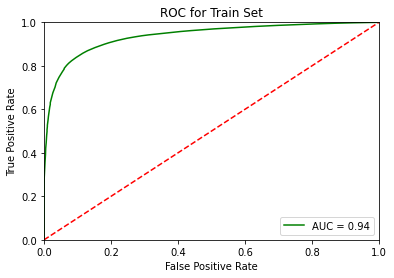

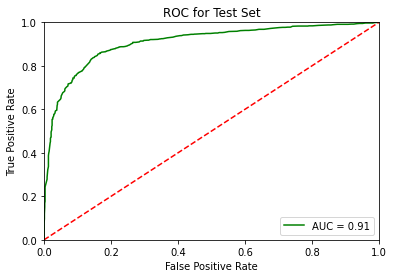

              precision    recall  f1-score   support

           1       0.85      0.90      0.88      6000
           2       0.90      0.84      0.87      6000

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000


              precision    recall  f1-score   support

           1       0.81      0.88      0.84      1000
           2       0.87      0.80      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000




Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[5422  578]
 [ 965 5035]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.84891185 0.90366667 0.87543392]
 [0.89702476 0.83916667 0.86713166]]

Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[876 124]
 [203 797]]

Precision Recall F1-Score (1st 

In [70]:
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt

naive_bayes = Naive_Bayes()
naive_bayes.fit(x_train, y_train)
y_train_pred = naive_bayes.predict(x_train)
y_test_pred = naive_bayes.predict(x_test)

## 3.3 (a)

print(confusion_matrix(y_train,y_train_pred))
print()
print(confusion_matrix(y_test,y_test_pred))


## 3.3 (b)

y_train_proba = naive_bayes.get_proba(x_train)
y_test_proba = naive_bayes.get_proba(x_test)

fpr, tpr, threshold = metrics.roc_curve(y_train, y_train_proba[:,1],pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC for Train Set')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_proba[:,1],pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC for Test Set')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()


## 3.3 (c)
print(classification_report(y_train,y_train_pred))
print()
print(classification_report(y_test,y_test_pred))

print("\n\n")
(confusionMatrix(y_train,y_train_pred))
print()
(confusionMatrix(y_test,y_test_pred))